# Basic working examples of parameter estimation

In [17]:
using Revise
using DifferentialEquations
using Thyrosim
using Plots
using DiffEqCallbacks
using DiffEqParamEstim
using Optim

┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1242
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = lstirling_asym(::BigFloat) at misc.jl:56
└ @ StatsFuns ~/.julia/packages/StatsFuns/2QE7p/src/misc.jl:56


## Import data 

Blakesley's patient employs average data.

+ 36 healthy patients, 18 women 18 men, 3 were excluded
+ They were given 400/450/600 μg of oral T4 dose at 24th hour. Measurements were make for up to 5 days
+ All patients have "normal weight for height" 

In [18]:
my_time, my400_data, my450_data, my600_data = blakesley_data()
tspan = (my_time[1], my_time[end])

(0.0, 120.0)

In [28]:
# T4, T3, TSH
my400_data

33×3 Array{Float64,2}:
  77.24  1.268  1.74 
  76.65  1.24   1.689
  77.9   1.258  1.579
  77.42  1.249  1.515
  77.92  1.229  1.433
  78.63  1.242  1.433
  79.0   1.227  1.398
  79.48  1.215  1.366
  78.64  1.18   1.146
  76.24  1.162  1.37 
  77.47  1.213  1.866
  76.61  1.19   1.712
  71.58  1.121  3.348
   ⋮                 
 123.5   1.244  1.564
 120.18  1.249  1.486
 112.44  1.214  1.11 
 111.65  1.244  1.17 
 110.73  1.247  1.401
 109.75  1.243  1.265
  99.48  1.18   1.983
  99.38  1.241  1.123
  95.41  1.179  0.854
  88.12  1.205  0.865
  84.02  1.147  0.987
  83.99  1.229  1.391

## Solve 1 patient

In [89]:
# initialize ODE problem, assuming male patient of average size and normal TSH values
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 

# designate p55 as oral T4 dose (400 mcg), p56 as oral T3 dose
p[55] = 400 / 777.0
p[56] = 0.0

# gives 400 mcg of oral T4 at hour 24
function condition(u, t, integrator)
    return t - 24.0
end
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
cbk = ContinuousCallback(condition, add_dose!);

# ODE problem
prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)

# solve ODE problem
sol = solve(prob);

## Plot result

Current plot looks weird because:
+ Need to calculate initial condition using steady state approximations
+ p[51] and p[52] is initialzed to be 11.0 and 5.0 respectively. Matlab's fitted values are 6.91 and 7.66. 

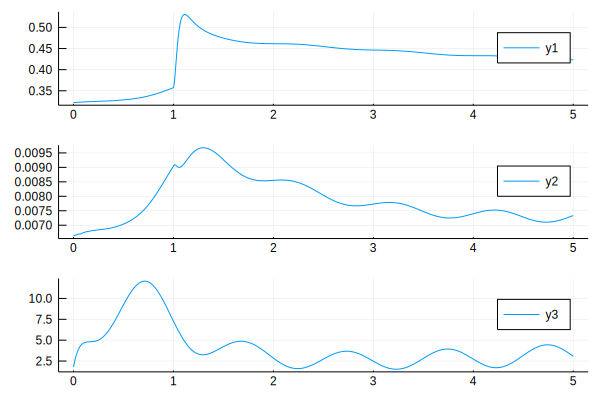

In [90]:
# T4, T3, TSH
plot(sol.t ./ 24, [sol[1, :] sol[4, :] sol[7, :]], layout = (3, 1))

### Changing parameters back indeed restores normal-ish looking plot:

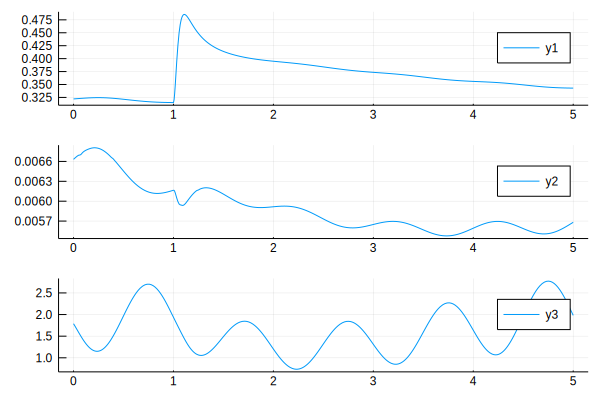

In [91]:
p[51] = 6.91
p[52] = 7.66

# ODE problem
prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)

# solve ODE problem
sol = solve(prob);

plot(sol.t ./ 24, [sol[1, :] sol[4, :] sol[7, :]], layout = (3, 1))

## Optimize blakesley error

Read about closures [here](http://julianlsolvers.github.io/Optim.jl/latest/#user/tipsandtricks/#_top). 

In [92]:
function fit_blakesley()
    # initialize initial guess and fitting index
    fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
    initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

    # import data
    my_time, my400_data, my450_data, my600_data = blakesley_data()
    data_400 = my400_data[:, 3]
    data_450 = my450_data[:, 3]
    data_600 = my600_data[:, 3]

    return optimize(p -> blakesley_objective(p, fitting_index, my_time, data_400, data_450, data_600), 
                        initial_guess, NelderMead())
end

fit_blakesley (generic function with 1 method)

### Test 1 run

In [78]:
my_time, my400_data, my450_data, my600_data = blakesley_data()
fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

data_400 = my400_data[:, 3]
data_450 = my450_data[:, 3]
data_600 = my600_data[:, 3]

fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

@show blakesley_objective(initial_guess, fitting_index, my_time, data_400, data_450, data_600)

blakesley_objective(initial_guess, fitting_index, my_time, data_400, data_450, data_600) = 1410.0787611799558


1410.0787611799558

In [81]:
@time result = optimize(p -> blakesley_objective(p, fitting_index, my_time, data_400, data_450, data_600), 
                        initial_guess, NelderMead())

 45.655647 seconds (102.16 M allocations: 3.403 GiB, 1.84% gc time)


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.14e+02, 5.45e+01, 5.71e+00,  ...]
    Minimum:   4.610022e+00

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [1.01e+02, 4.76e+01, 4.57e+00,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   45  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1612


In [83]:
[result.minimizer initial_guess]

8×2 Array{Float64,2}:
 113.512     101.0 
  54.4605     47.64
   5.70674     4.57
   3.94917     3.9 
  13.228      11.0 
   7.79496     5.0 
   0.470769    3.5 
   1.8858      8.0 

In [72]:
#main objective function for TSH error only
function blakesley_objective(p_being_optimized, fitting_index, time, my400_data, my450_data, my600_data)
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= p_being_optimized
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(condition, add_dose!); 
    
    # solve different ODE problems for varying doses
    p_400 = p_450 = p_600 = copy(p)
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=7)
    sol_450 = solve(prob_450, save_idxs=7)
    sol_600 = solve(prob_600, save_idxs=7)
    
    return blakesley_error(sol_400, time, my400_data) + 
           blakesley_error(sol_450, time, my450_data) + 
           blakesley_error(sol_600, time, my600_data)
end

blakesley_objective (generic function with 2 methods)

## Test one function call

In [71]:
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
tspan = (0.0, 120.0)
cbk   = ContinuousCallback(condition, add_dose!); 

# solve different ODE problems for varying doses
p_400 = p_450 = p_600 = copy(p)
p_600[55] = 600.0 / 777.0
prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
sol_600 = solve(prob_600, save_idxs=7)

blakesley_error(sol_600, my_time, data_600)

446.04133210034337

In [88]:
# helper function for calculating the error
function blakesley_error(sol, time, data)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            t = time[i]
            tot_loss += (sol(t) - data[i])^2
        end
    end
    return tot_loss
end

blakesley_error (generic function with 1 method)

# Check optimization result by plotting

In [10]:
# some code for plotting
function plot_blakesley(sol, which="400")
    markersize = 2
    t_data, data400, data450, data600 = blakesley_data()
    if which == "400"
        data = data400
    elseif which == "450"
        data = data450
    else
        data = data600
    end
    
    t_data = t_data / 24.0

    ## Need to change to pick better y limits!
    p = sol.prob.p 
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 140), label="",
       ylabel="T4", title="Thyrosim simulation (Blakesley data)")
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, data[:, 1], label="", markersize=markersize)
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, data[:, 2], label="", markersize=markersize)
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, data[:, 3], label="", markersize=markersize)
    
    plot(p1, p2, p3, layout=(3, 1))
end

plot_blakesley (generic function with 2 methods)

In [85]:
# check if fitting is better by plotting
ic, p = initialize([1.0; 0.88; 1.0; 0.88])
p[55] = 400.0 / 777.0
old_prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
old_sol  = solve(old_prob)

p[fitting_index] = result.minimizer
new_prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
new_sol  = solve(new_prob);

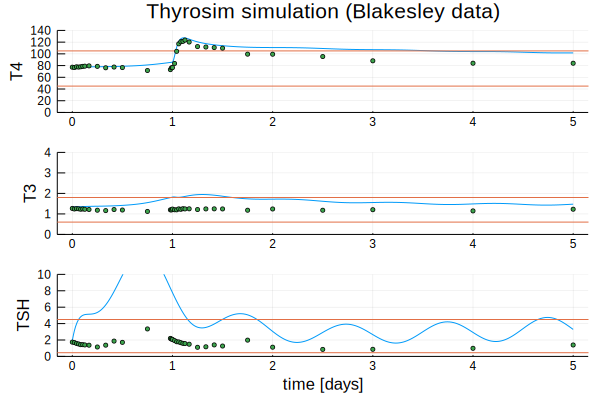

In [86]:
plot_blakesley(old_sol, "400")

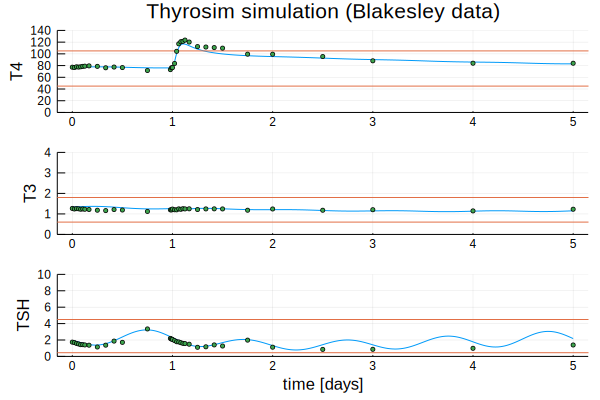

In [87]:
plot_blakesley(new_sol, "400")